# BMI/CS 576 HW1
The objectives of this homework are to practice

* with the basic algorithms for sequence assembly
* reasoning about graphs and paths for the sequence assembly task

## HW policies
Before starting this homework, please read over the [homework policies](https://canvas.wisc.edu/courses/374201/pages/hw-policies) for this course.  In particular, note that homeworks are to be completed *individually* and plagiarism from any source (with the one exception noted below) will be considered **academic misconduct**.

You are welcome to use any code from the weekly notebooks (including the official solutions) in your solutions to the HW.

## PROBLEM 1: A "sometimes greedy" algorithm for fragment assembly (50 points)
Write a function, `sometimes_greedy_assemble`, that takes as input a list of read strings and uses a modified version of the greedy fragment assembly algorithm to assemble them into a single superstring.  We will consider a modification to the greedy algorithm described for fragment assembly (Page 9 of the [Sequence Assembly - Graphs and fragment assembly](https://canvas.wisc.edu/courses/374201/pages/day-4-online-lecture-sequence-assembly-graphs-and-fragment-assembly)) in which the algorithm does not always add the next (largest overlap) compatible edge from the queue.  Instead, after popping the next edge off of the queue and checking that it is compatible with the current graph, we will choose to add it to the graph with probability $p$, and if not, we will instead add it to a list, $H$, of "held aside" edges that will be considered later, and then continue with the algorithm.  The modified pseudocode for the algorithm is:

* Let $G$ be a graph with fragments as vertices and no edges
* Create a queue, $Q$, of overlap edges (not currently in $G$), with edges in order of increasing weight (decreasing overlap length)
* Initialize $H$ to be an empty list
* While $G$ is disconnected
    * Pop the next possible edge $e = (u, v)$ off of $Q$
    * If $outdegree(u) = 0$ and $indegree(v) = 0$ and $e$ does not create a cycle
        * Let $x$ be a random number drawn uniformly from $[0, 1)$
        * If $x < p$
            * add *e* to *G*
            * move the edges in $H$ back to $Q$ in sorted order
        * Else
            * add *e* to *H*
    * If $Q$ is empty
        * move the edges in $H$ back to $Q$ in sorted order

A potential advantage of this randomized algorithm is that, in cases where the deterministic greedy algorithm fails to find the shortest superstring, there is a non-zero probability that the randomized algorithm will find a shorter superstring than the deterministic algorithm.  And we can run the randomized algorithm many times to increase these chances.

To keep things simple for this homework we will allow overlaps of any length (including zero).  In practice, we would typically require some minimum overlap length.  For simplicity, we will also assume that:
1. we are assembling a single-stranded sequence and
2. that no read is a substring of any other read.

## Important implementation details

### Random number generation 
Random number generation should occur only at the line specified in the pseudocode, and you should use the [random.random](https://docs.python.org/3/library/random.html#random.random) function for this purpose.

### Tie-breaking criteria

For the purpose of making this algorithm deterministic, we must establish tiebreaking criteria for edges in the overlap graph that have the same weight. For two edges with the same weight, we will first choose the edge whose source vertex read is first in lexicographical order. If the source vertices are identical, then we choose the edge whose target vertex read is first in lexicographical order. For example, if e1 = ATCGGA → GGAT and e2 = ATCGGA → GGAA, we will attempt to use edge e2 first because GGAA < GGAT according to lexicographical order.  You may find useful the fact that comparison operators for sequences in Python (e.g., tuples) use lexicographical ordering.  For example,

In [5]:
(-3, "ATCGGA", "GGAA") < (-3, "ATCGGA", "GGAT")

True

In [6]:
from graph import *
import greedy
import random
from itertools import combinations
import queue

In [7]:
# Code for PROBLEM 1
# You are welcome to develop your code as a separate Python module
# and import it here if that is more convenient for you.
def sometimes_greedy_assemble(reads, p=1.0):
    """Assembles a set of reads using the graph-based 'sometimes' greedy algorithm.
    
    Args:
        reads: a list of strings
        p: probability of a compatible edge being added at each iteration
           (default: 1.0, which is equilavent to the deterministic greedy algorithm)
    Returns:
        A string that is a superstring of the input reads
    """
    reads = sorted(reads)
    g = AdjacencyListDirectedGraph(len(reads))
    h = []
    q = []
    e = []
    
    #make edges with list combination to find all cases
    # edges = list(combinations(reads,2))
    for i in range(len(reads) -1):
        for j in range(i+1, len(reads)):
            #find overlap part
            s1,s2 = reads[i], reads[j]
            overlap = greedy.overlap_length(s1, s2)
            overlap2 = greedy.overlap_length(s2, s1)
            #append it on queue (put - in front of overlap)
            q.append((-(overlap), i, j))
            q.append((-(overlap2), j, i))
            
        
    #sorted queue as descending -> compare [0][1][2]
    q.sort(key = lambda i:[i[0],i[1],i[2]], reverse = True)
    # q.sort(key = lambda i:[i[0],reads[i[1]],reads[i[2]]], reverse = True)

    #make g as vertex graph
    g = VertexLabeledALDirectedGraph(g.num_vertices())
    for i in range(g.num_vertices()):
        #labeled all vertexs
        g.set_vertex_label(i, reads[i])
        
    #make new def to check connection of graph
    def check_connect(g):
        count = g.num_edges() 
        if count == g.num_vertices() - 1:
            return True

    #run while g is connected -> if it connected it will out of the loop
    while not check_connect(g):
        #pop the last edge - w(weight), o(outdegree), i(indegree)
        (w, o ,i) = q.pop()
        #if outdegree() = 0 ans indegree() = 0 and edge does not create a cycle
        if g.outdegree(o) == 0 and g.indegree(i) == 0 and g.cycle(o,i) == False:
            #x = random num [0,1)
            x = random.random()
            if x < p:
                # g.append(o,i)
                g.add_edge(o, i)
                e.append((o,i))
                for hh in h:
                    #move edges in H back to Q in sorted order
                    q.append(hh)
                q.sort(key = lambda i:[i[0],i[1],i[2]], reverse = True)
                h = []
            else:
                #move edges in H back to Q in sorted order
                h.append((w,o,i))
        if len(q) == 0:
            for hh in h:
                q.append(hh)
            h = []
            q.sort(key = lambda i:[i[0],i[1],i[2]], reverse = True)
    
    start = 0
    sequence = [reads[start]]
    while(1):
        if len(g._out_lists[start]) == 0:
            break
        else:
            start = g._out_lists[start][0]
            sequence.append(reads[start])
    start = 0
    while(1):
        if len(g._in_lists[start]) == 0:
            break
        else:
            start = g._in_lists[start][0]
            sequence = [reads[start]] + sequence        
        
    ans = greedy.merge_ordered_reads(sequence)
    return ans
                               
        

Tests for `sometimes_greedy_assemble` are provided at the bottom of this notebook.

## PROBLEM 2: Assembling the SARS-CoV-2 genome (10 points)

Included with this notebook is the file `sarscov2_reads.fasta` which is a set of reads from a SARS-CoV-2 variant genome.  In this problem, we will use your `sometimes_greedy_assemble` function to assemble this genome and then *determine the identity of the variant*.  A few notes about these reads:

1. The reads are free of sequencing errors
2. The reads are all in the same orientation as the SARS-CoV-2 genome

**(a)** Write code to read in the SARS-CoV-2 reads and assemble them with your `sometimes_greedy_assemble` function, with `p = 1` (deterministic).  Write the code assuming your `sometimes_greedy_assemble` function is correct.  This problem will be graded manually.  

In [8]:
def readFasta(file):
    s = []
    with open(file,'r') as f:
        current = ""
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if current == "":
                    continue
                else:
                    s.append(current)
                    current = ""
            else:
                current += line
    return s
        
            

sarscov2_reads = readFasta('sarscov2_reads.fasta')
print(sometimes_greedy_assemble(sarscov2_reads,p = 1))
# print(sarscov2_reads)


AAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGACACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCATTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACAT

**(b)** The file `sarscov2_variant_genomes.fasta` contains the genome sequences for eight SARS-CoV-2 variants of concern or variants of interest: alpha, beta, delta, gamma, epsilon, omicron BA.1, omicron BA.4, omicron BA.5, omicron EG.5.1, and omicron XBB.1.5  If your code is correct, your assembly should be identical to one of these genomes (*note: typically, a newly sequenced viral genome will not match exactly to a reference genome, but we are keeping it simple in this assignment*).  **Which variant do these reads come from?**

A few notes:
1. If your `sometimes_greedy_assemble` function is not correct, you may use an alternative strategy for determining the identity of the variant (e.g., by examining the reads and the candidate variant genome sequences provided)
2. This problem will be manually graded.  The majority of the credit will be providing the code that you used to determine the identity of the variant.

In [9]:
sarscov2_reads = readFasta('sarscov2_variant_genomes.fasta')
print(sometimes_greedy_assemble(sarscov2_reads,p = 1))


TTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGGTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAA

## PROBLEM 3: SBH graphs and Eulerian paths (20 points) 
For the following strings, (i) give the k = 3 spectrum for the string, (ii) draw the SBH graph for the spectrum, (iii) give one Eulerian path and its corresponding string for the SBH graph, and (iv) show whether or not there exists an Eulerian path in the graph that corresponds to the original string.

(a) `AGTTAAATTGCAG`

(b) `TATCGGATCGTTA`

###
### *YOUR ANSWER TO PROBLEM 3 HERE*
###


In [10]:
from PIL import Image
from IPython.display import display

# 3 (a)

(i) k = 3 

AGT, GTT, TTA, TAA, AAA, AAT, ATT, TTG, TGC, GCA, CAG

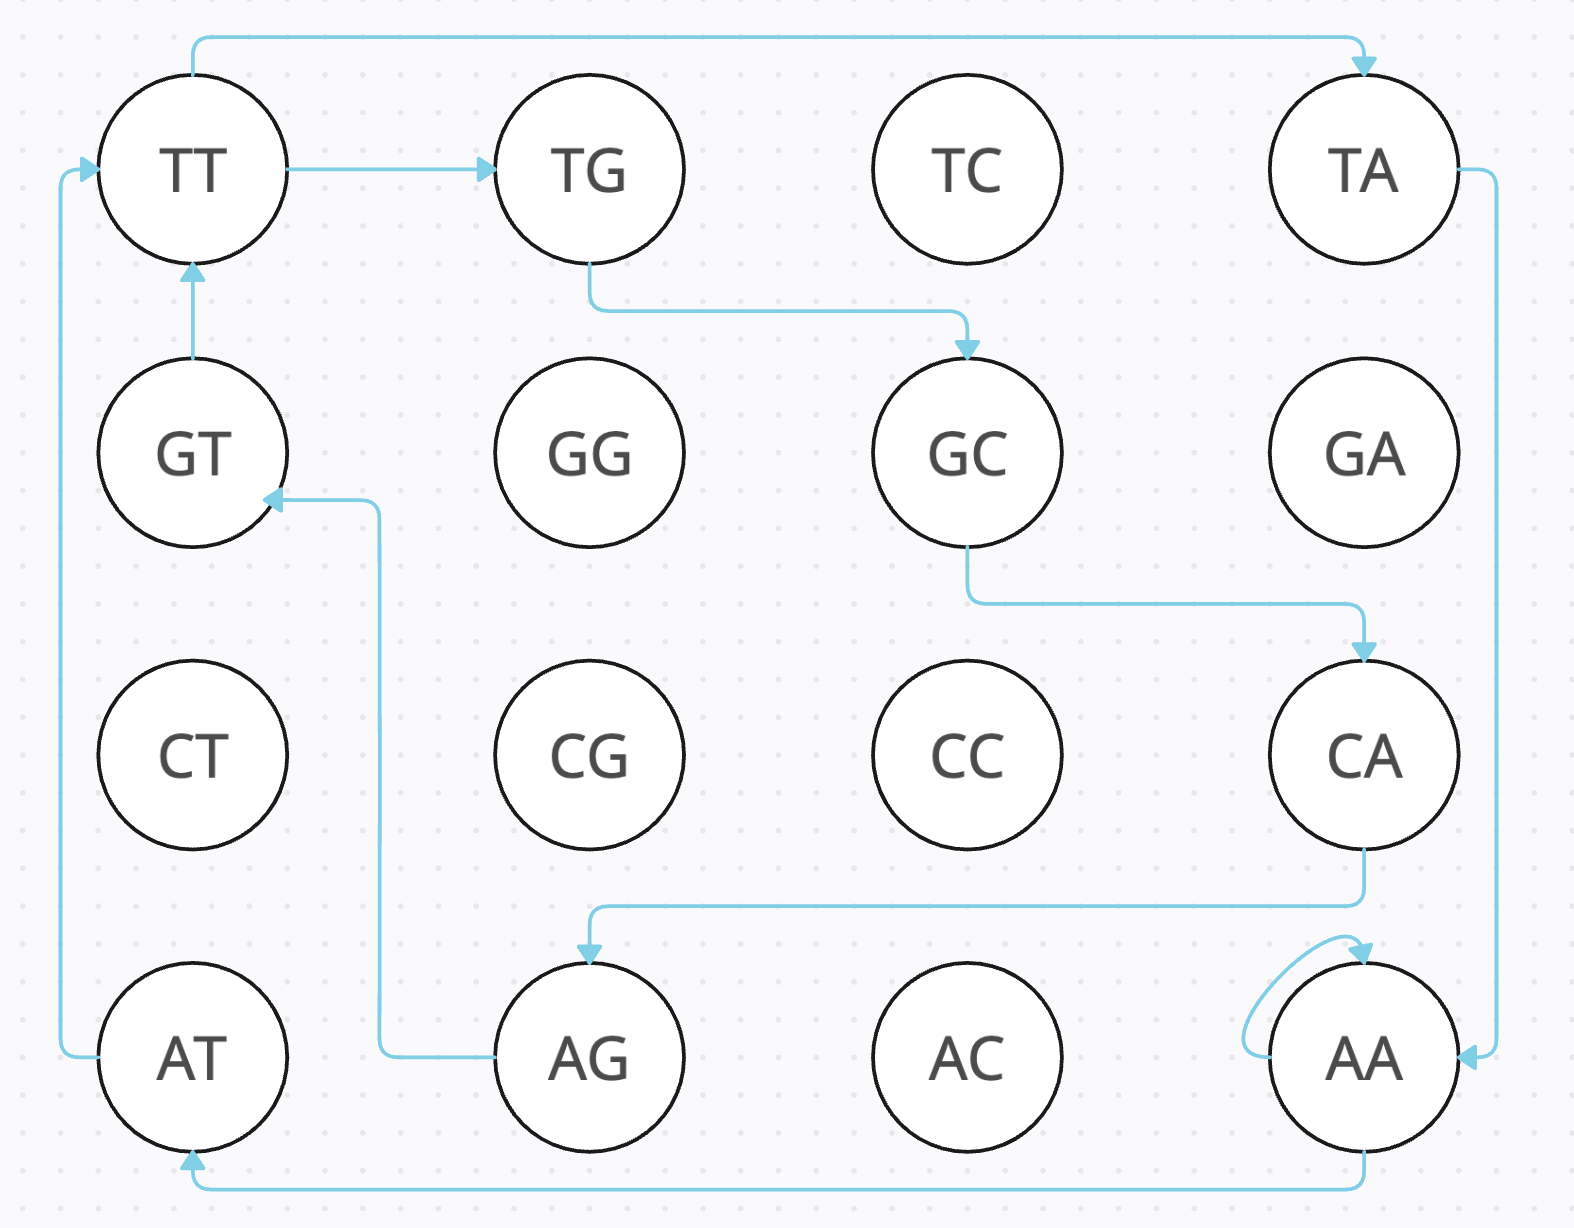

In [11]:
#(ii) draw the SBH graph
img = Image.open("3-(1).png")
display(img)

(iii) give one Eulerian path and its corresponding string for the SBH graph

AG -> GT -> TT -> TG -> GC -> CA -> AG

TT -> TA -> AA -> AA -> AT -> TT

AG -> GT -> TT -> TA -> AA -> AA -> AT -> TT -> TG -> GC -> CA -> AG

(iv) show whether or not there exists an Eulerian path in the graph that corresponds to the original string.

To be an Eulerian path, all vertor's (except first and last vectors) edges should be even, while the first and the last vertices edges are odd. Moreover, graph must be connected. 

>AGT (in: 0, out: 1)
GTT (in: 1, out: 1)
TTA (in: 1, out: 1)
TAA (in: 1, out: 1)
AAA (in: 2, out: 2)
AAT (in: 1, out: 1)
ATT (in: 1, out: 1)
TTG (in: 1, out: 1)
TGC (in: 1, out: 1)
GCA (in: 1, out: 1)
CAG (in: 1, out: 0)

For this string it has path like this; AGT -> GTT -> TTA -> TAA -> AAA -> AAT -> ATT -> TTG -> TGC -> GCA -> CAG. On this graph the first and the last vectors have one edge and other vectors have two or four edges for each. Also, all the vertices connected, which mean it is an Eulerian path.

# 3 (b)

(i) k = 3 

TAT, ATC, TCG, CGG, GGA, GAT, ATC, TCG, CGT, GTT, TTA

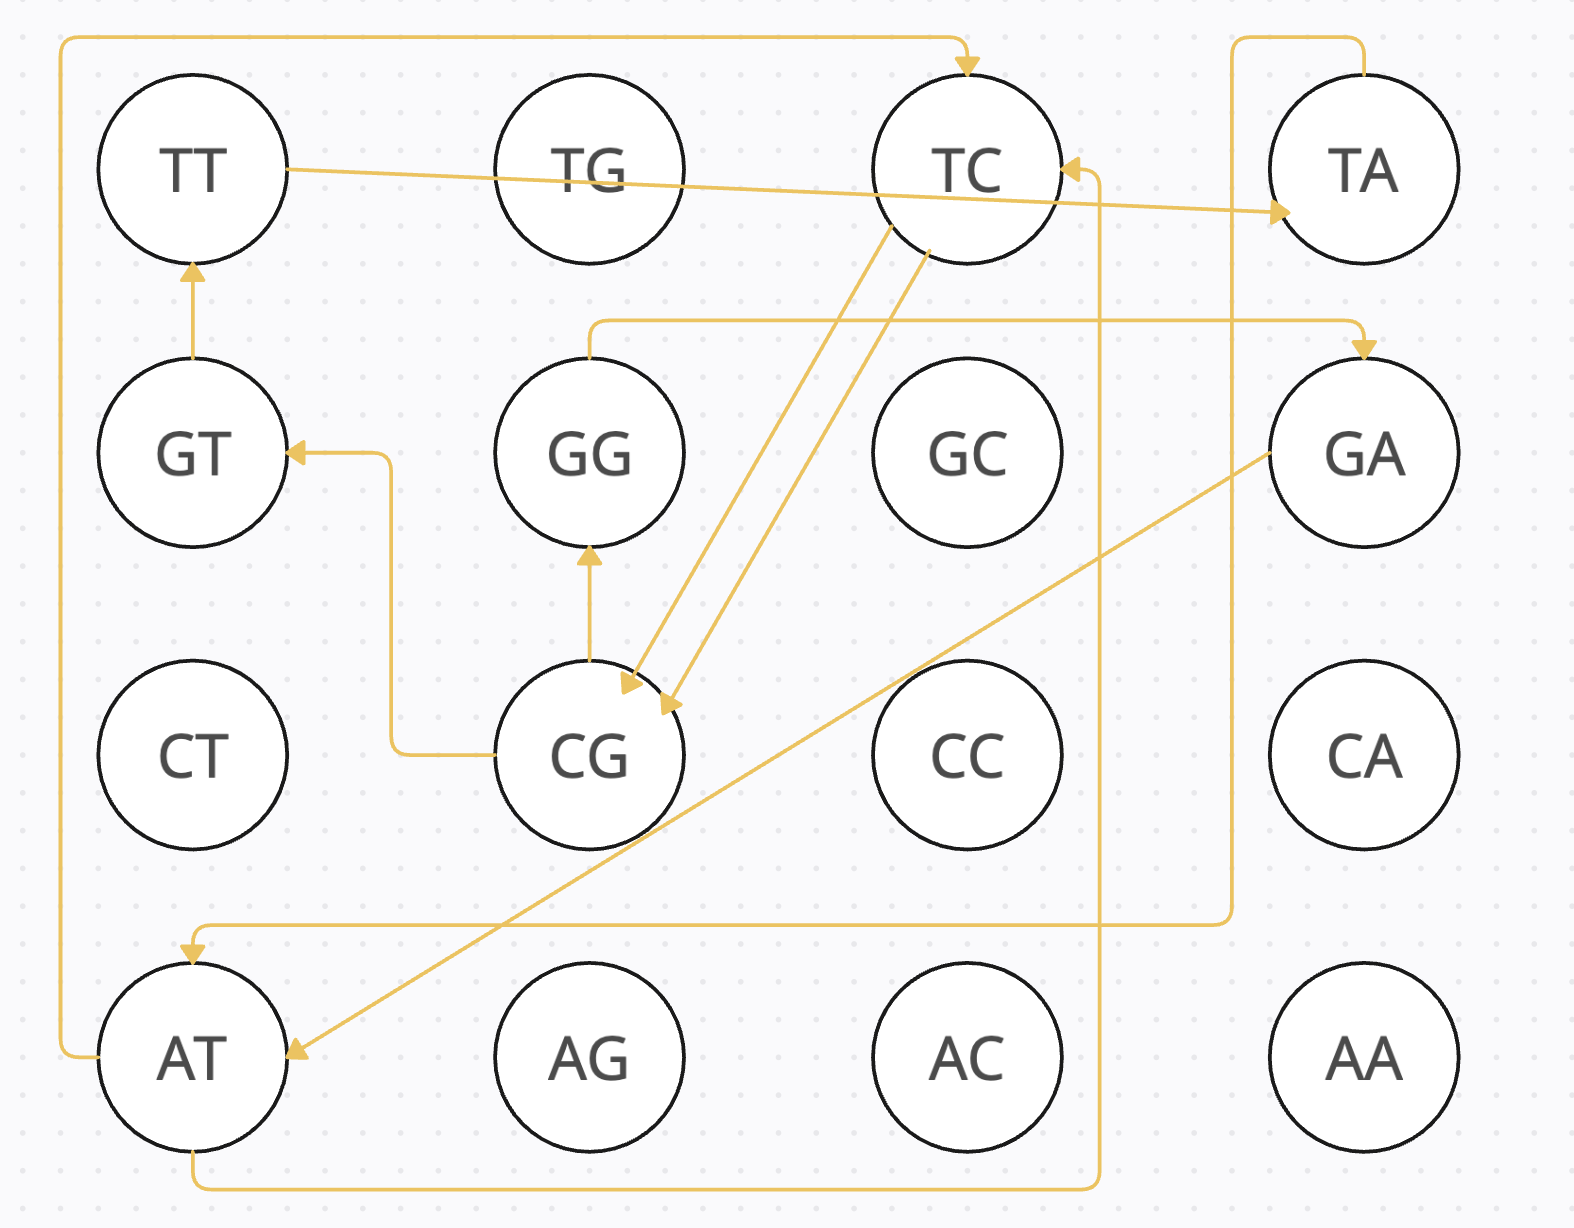

In [12]:
#(ii) draw the SBH graph
img = Image.open("3-(2).png")
display(img)

(iii) give one Eulerian path and its corresponding string for the SBH graph

TA -> AT -> TC -> CG -> GT -> TT -> TA

AT -> TC -> CG -> GG -> GA -> AT

TA -> AT -> TC -> CG -> GG -> GA -> AT -> TC -> CG -> GT -> TT -> TA

(iv) show whether or not there exists an Eulerian path in the graph that corresponds to the original string.

Same as the previous graph, all vertices in this graph have balanced in edges.

>TAT (in: 0, out: 1)
ATC (in: 2, out: 2)
TCG (in: 2, out: 2)
CGG (in: 1, out: 1)
GGA (in: 1, out: 1)
GAT (in: 1, out: 1)
CGT (in: 1, out: 1)
GTT (in: 1, out: 1)
TTA (in: 1, out: 0)

It is connected and except first and last vertex, all vertices have even number of edges. This is also Eulerian path.


## PROBLEM 4: Which data will assemble correctly? (20 points) 
Suppose that the true genome sequence of an organism is `AACGCCGCTAG`.

**(a)** Suppose you use the fragment assembly paradigm and the greedy algorithm for assembling these three reads into a superstring.

**(a.i)** Identify three reads, each with length = 5, that cover the genome and for which the algorithm will *successfully* assemble the genome.  Draw the overlap graph and specify the order in which the edges are added to form the path.

**(a.ii)** Identify three reads, each with length = 5, that cover the genome and for which the algorithm will *fail* to assemble the genome.  Draw the overlap graph and specify the order in which the edges are added to form the path.

**(a.iii)** Identify three reads, each with length = 5, that cover the genome and for which the algorithm *may fail or may succeed* depending on how edge weight ties are arbitrarily broken.  Draw the overlap graph and specify the order in which the edges are added to form a correct assembly and also an order in which the edges are added to form an incorrect assembly.

**(b)** Suppose instead that you use the spectral assembly paradigm.  What is the smallest value of $k$ for which this assembly approach will succeed?  For this value of $k$, give the spectral assembly graph and an Eulerian path through the graph.

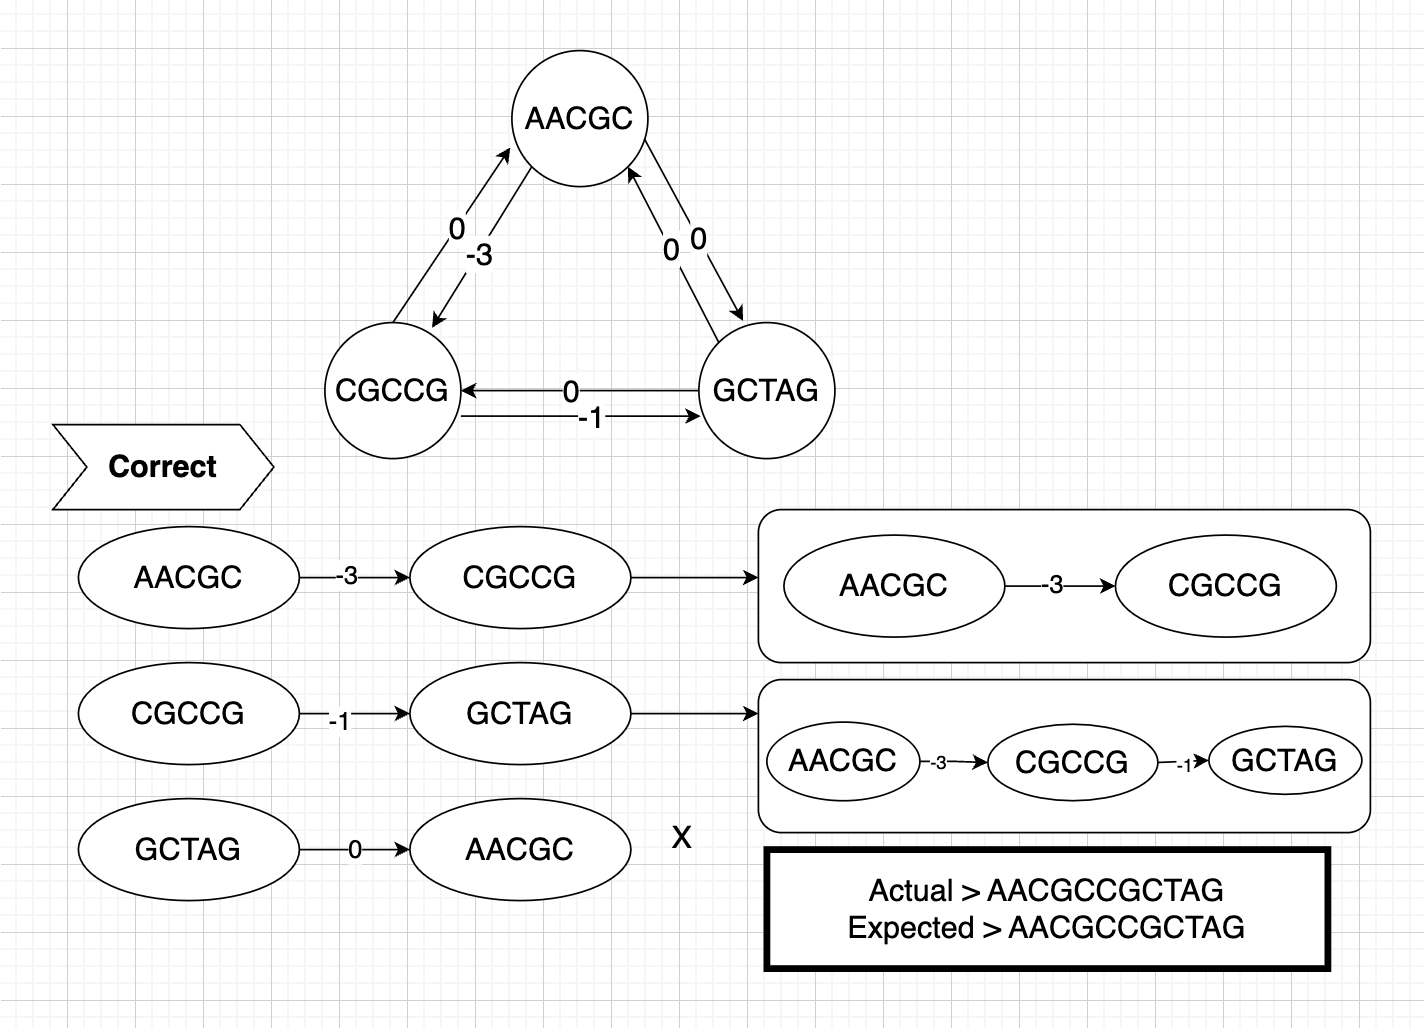

In [13]:
#(a.i) AACGCCGCTAG  -> AACGC CGCCG GCTAG
#(i) draw the overlap graph -> 100% success
img = Image.open("4 -(a.i).png")
display(img)

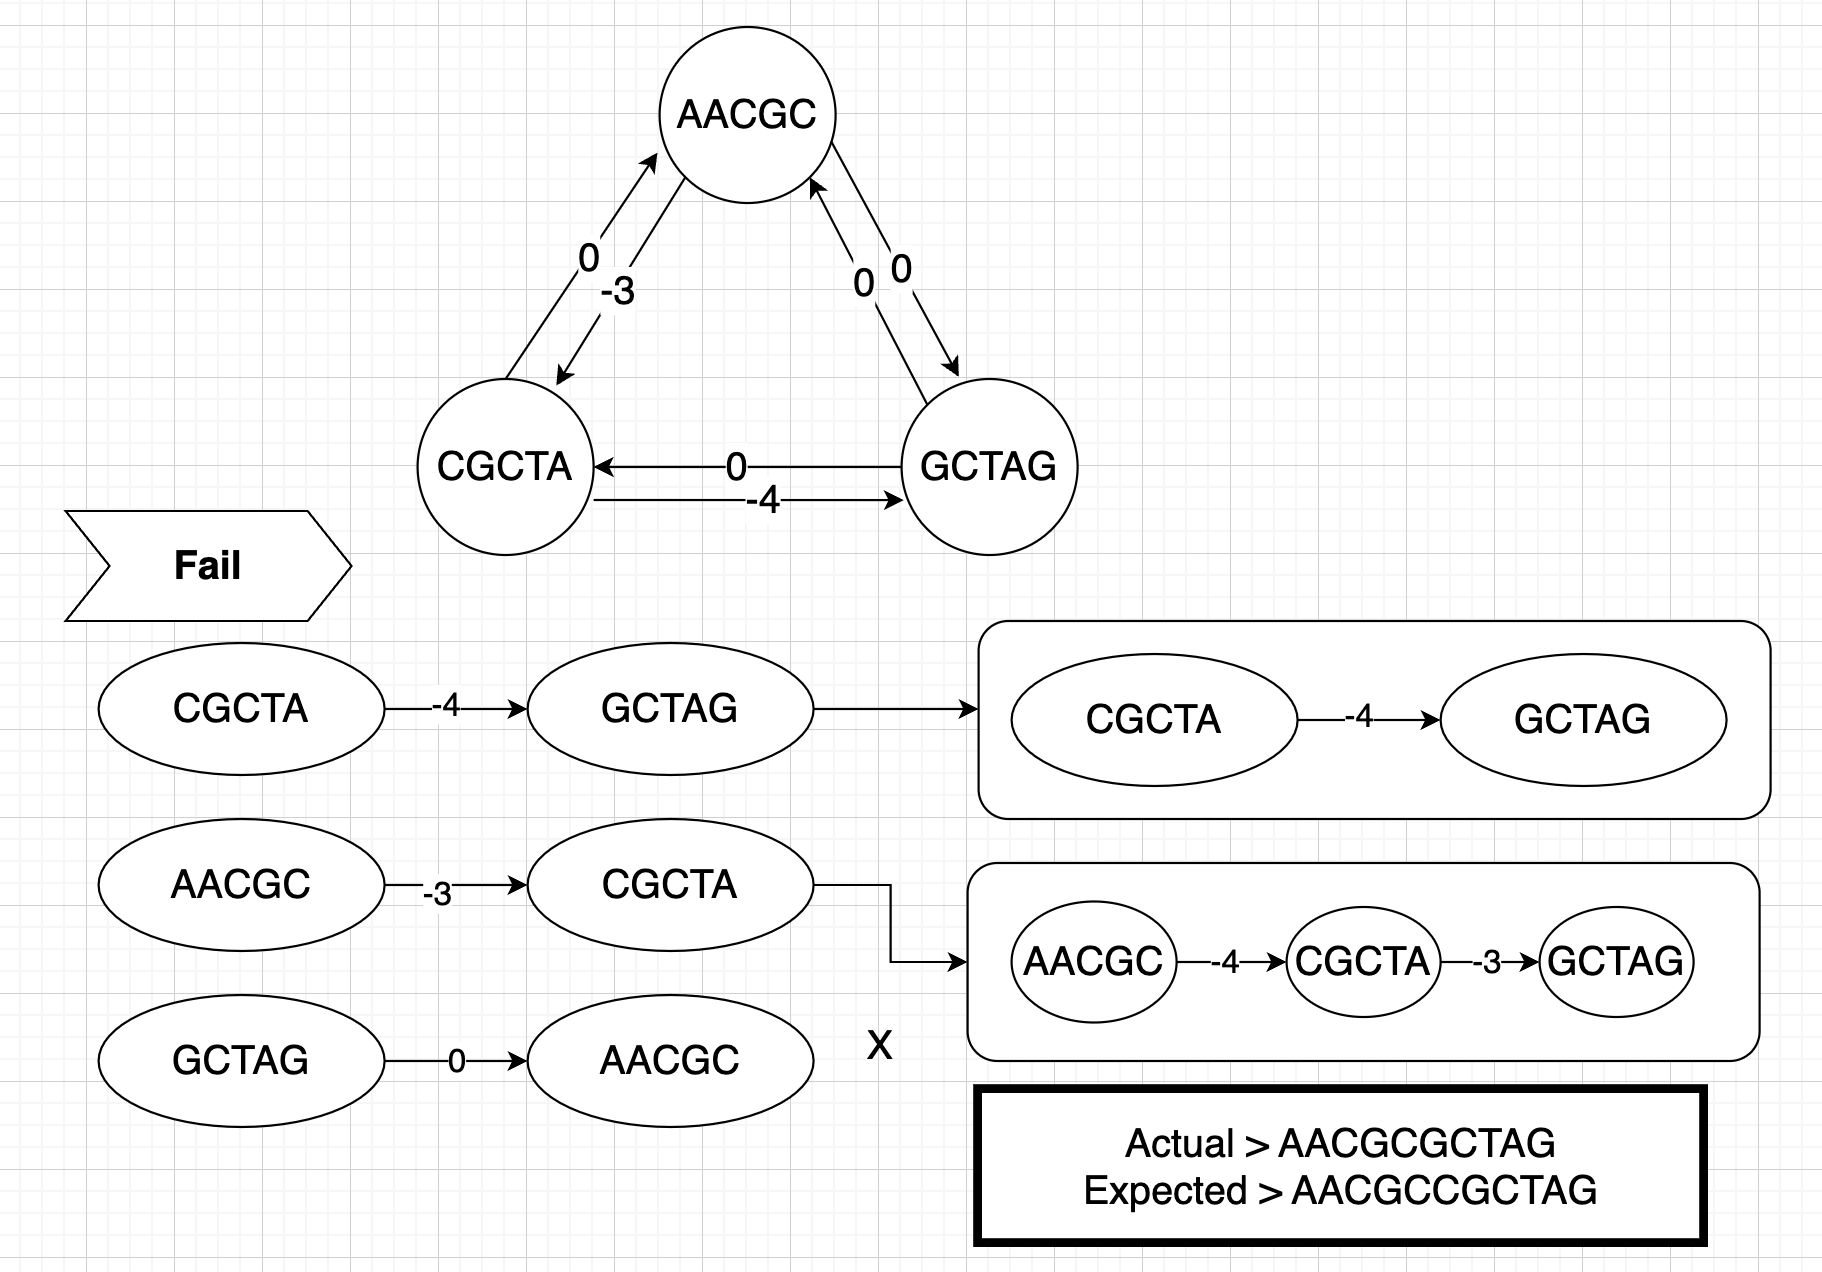

In [14]:
#(a.ii) AACGCCGCTAG  -> AACGC ACGCC GCTAG
#(ii) draw the overlap graph -> 100% fail
img = Image.open("4 -(a.ii).png")
display(img)

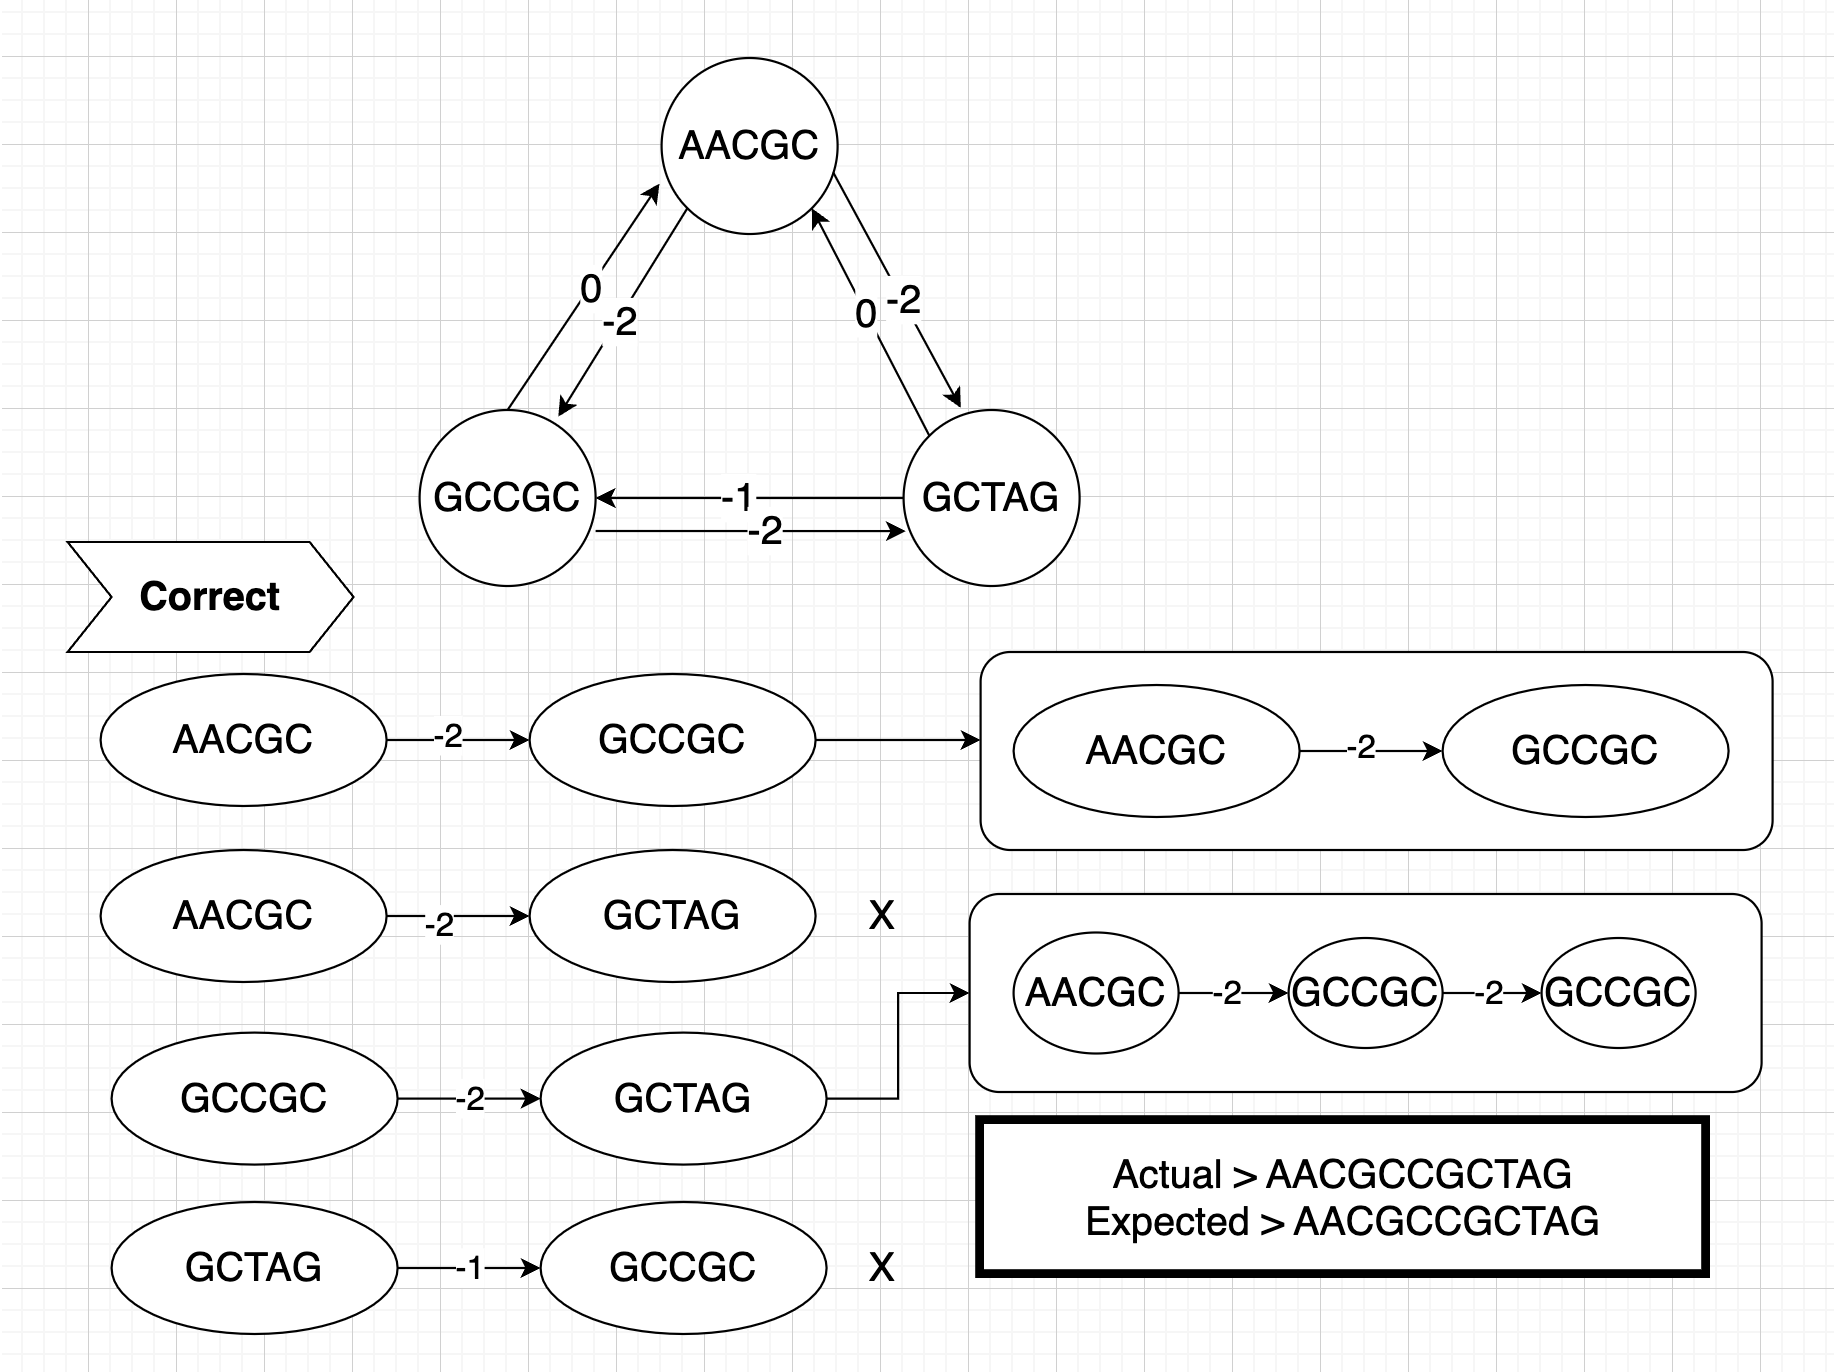

In [15]:
#(a.iii) AACGCCGCTAG  -> AACGC GCCGC GCTAG
#(iii) draw the successfully overlap graph (50%)
img = Image.open("4- successfully.png")
display(img)

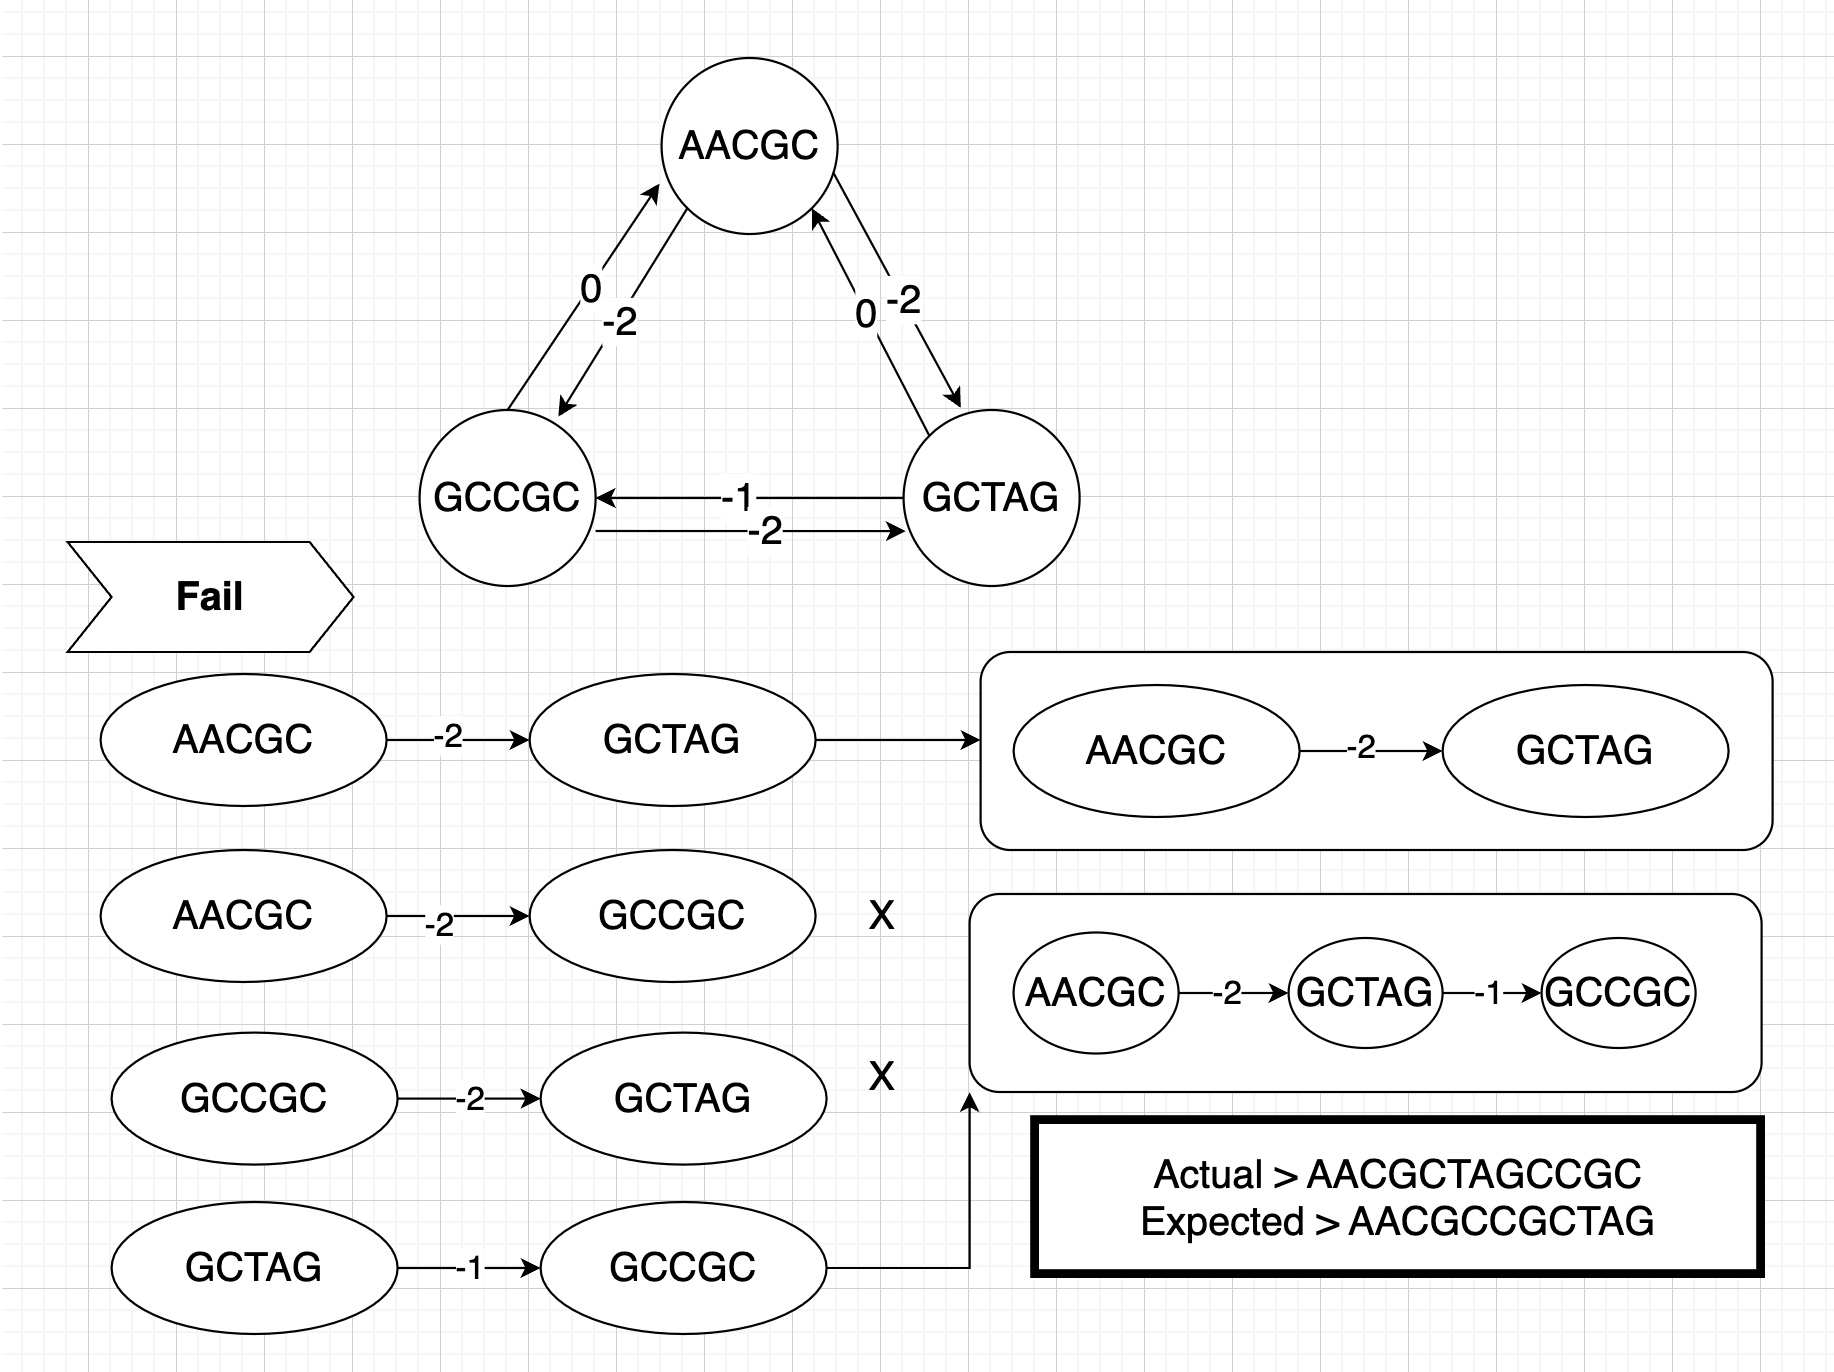

In [16]:
#(iii) draw the fail overlap graph (50%)
img = Image.open("4- fail.png")
display(img)

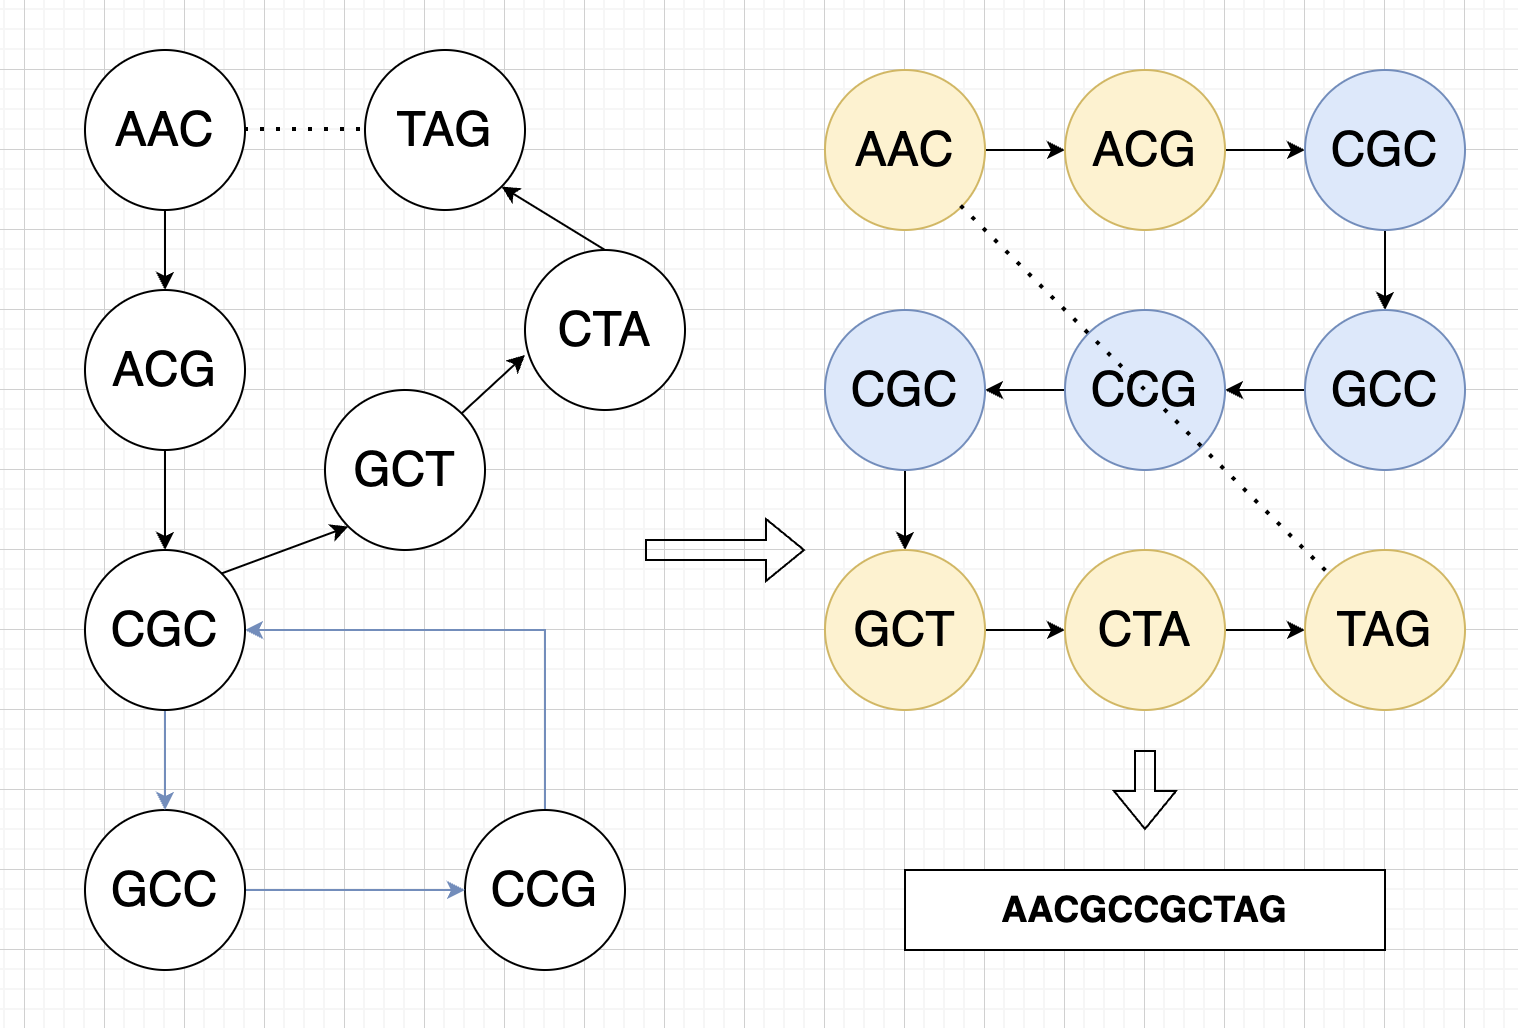

In [17]:
#(b)give the spectral assembly graph and an Eulerian path through the graph
# K = 3
img = Image.open("4 -(b).png")
display(img)

###
### *YOUR ANSWER TO PROBLEM 4 HERE*
###


### Tests for problem 1

In [18]:
# read sets for testing
tiny_reads = ["ATAG", "CATA", "TAAT"]
single_base_reads = ["C", "A", "T", "G"]
medium_reads = ["ATGCT", "CTAT", "CCTATA", "CCC", "CTCC", "AAG"]

# utility functions for testing
import random

def read_strings_from_file(filename):
    return [line.rstrip() for line in open(filename)]

def test_sometimes_greedy_assemble_with_files(reads_filename, superstring_filename, p = 1.0):
    reads = read_strings_from_file(reads_filename)
    superstring = read_strings_from_file(superstring_filename)[0]
    assert sometimes_greedy_assemble(reads, p) == superstring

In [19]:
# TEST: returns a string (8 POINTS)
assembly = sometimes_greedy_assemble(tiny_reads)
assert isinstance(assembly, str), "Return value of sometimes_greedy_assemble is not a str"
print("SUCCESS: returns a string passed!")

SUCCESS: returns a string passed!


In [20]:
# TEST: returns a superstring (6 POINTS)
def check_is_superstring(assembly, reads):
    for read in reads:
        assert read in assembly, f"read '{read}' is not contained in assembly"

assembly = sometimes_greedy_assemble(tiny_reads)
check_is_superstring(assembly, tiny_reads)
print("SUCCESS: returns a superstring passed!")

SUCCESS: returns a superstring passed!


In [21]:
# TEST: tiny_deterministic (4 POINTS)
assembly = sometimes_greedy_assemble(tiny_reads, 1.0)
assert assembly == 'CATAGTAAT'
print("SUCCESS: tiny_deterministic passed")

SUCCESS: tiny_deterministic passed


In [22]:
# TEST: tiny_single_skip (4 POINTS)
random.seed(0)
assembly = sometimes_greedy_assemble(tiny_reads, 0.8)
assert assembly == 'CATAATAG'
print("SUCCESS: tiny_single_skip passed!")

SUCCESS: tiny_single_skip passed!


In [23]:
# TEST: tiny_double_skip (2 POINTS)
random.seed(78)
assembly = sometimes_greedy_assemble(tiny_reads, 0.8)
assert assembly == 'ATAGCATAAT'
print("SUCCESS: tiny_double_skip passed!")

SUCCESS: tiny_double_skip passed!


In [24]:
# TEST: tiny_triple_skip (2 POINTS)
random.seed(23)
assembly = sometimes_greedy_assemble(tiny_reads, 0.8)
assert assembly == 'ATAGCATAAT'
print("SUCCESS: tiny_triple_skip passed!")

SUCCESS: tiny_triple_skip passed!


In [25]:
# TEST: tiny_empty_queue (2 POINTS)
import random
random.seed(17)
assembly = sometimes_greedy_assemble(tiny_reads, 0.8)
assert assembly == 'CATAGTAAT'
print("SUCCESS: tiny_empty_queue passed!")

SUCCESS: tiny_empty_queue passed!


In [26]:
# TEST: tiny_multiple_empty_queue (2 POINTS)
import random
random.seed(36)
assembly = sometimes_greedy_assemble(tiny_reads, 0.5)
assert assembly == 'TAATCATAG'
print("SUCCESS: tiny_multiple_empty_queue passed!")

SUCCESS: tiny_multiple_empty_queue passed!


In [27]:
# TEST: single_bases (2 POINTS)
assembly = sometimes_greedy_assemble(single_base_reads)
assert assembly == "ACGT"
print("SUCCESS: single_bases passed!")

SUCCESS: single_bases passed!


In [28]:
# TEST: medium (2 POINTS)
assembly = sometimes_greedy_assemble(medium_reads)
assert assembly == "CTCCCTATAAGATGCTAT"
print("SUCCESS: medium passed!")

SUCCESS: medium passed!


In [29]:
# TEST: medium_randomized (2 POINTS)
random.seed(15)
assembly = sometimes_greedy_assemble(medium_reads, p=0.7)
assert assembly == "CTATGCTCCCTATAAG"
print("SUCCESS: medium_randomized passed!")

SUCCESS: medium_randomized passed!


In [30]:
# TEST: large0 (4 POINTS)
random.seed(0)
test_sometimes_greedy_assemble_with_files("tests/large0_reads.txt", "tests/large0_assembly.txt", p = 0.8)
print("SUCCESS: large0 passed!")

SUCCESS: large0 passed!


In [31]:
# TEST: large1 (2 POINTS)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [32]:
# TEST: large2 (2 POINTS)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [33]:
# TEST: large3 (2 POINTS)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [34]:
# TEST: large4 (2 POINTS)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [35]:
# TEST: large5 (2 POINTS)
###
### AUTOGRADER TEST - DO NOT REMOVE
###
